In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import cantera as ct
import matplotlib.pyplot as plt
import json

# Importing packages
import feedstock as fs
import pp
import gasifier as g
import fuel as fu
import energy as en
import outputs as op

For species Fe(c), discontinuity in cp/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  0.0
	Value computed using high-temperature polynomial: 4.2881898

For species Fe(c), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  0.0
	Value computed using high-temperature polynomial: 3.425820683333331

For species Fe(c), discontinuity in s/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  0.0
	Value computed using high-temperature polynomial: 8.486560101557188

For species Cr(cr), discontinuity in cp/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  749.1520512400002
	Value computed using high-temperature polynomial: 0.0

For species Cr(cr), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  113.24055562733336
	Value computed using high-temperature polynomial: 0.0

For species Cr(cr), discontinuity in s/R detec

In [2]:
# # Grabbing data from JSON file
# with open('data/data.json','r') as dataFile:
#     data = json.load(dataFile)
#     dataFile.close()

In [3]:
# Table2 = data['Thamavithya2010']['Table2']
# df = pd.DataFrame(Table2)
# df.head()

In [4]:
# fuelID = "ThamaSawdust"
# species=['CO','H2','CH4','CO2','N2']
# moist = fu.moisture(fuelID)
# n = len(Table2)
# ER = np.array([run['ER'] for run in Table2])
# T = np.array([run['Tgas'] for run in Table2]) + 273.15 # K
# experimental = np.zeros((n, len(species)))
# for i in range(n):
#     for j, sp in enumerate(species):
#         experimental[i,j] = Table2[i][sp]/100
# CC = np.array([run['CarbonConv'] for run in Table2])

In [5]:
# predicted = np.zeros_like(experimental)
# for i in range(n):
#     report0 = g.gasifier(fuelID, moist=moist, T=T[i], air=ER[i], airType='ER', species=species)
#     CC_pred = report0['CC']
#     C_avail0 = CC[i]/CC_pred
#     DT, sqerr = g.findTquasi(fuelID, experimental[i], moist=moist, T0=T[i], air=ER[i], airType='ER', C_avail=1.0, species=species)
#     report1 = g.gasifier(fuelID, moist=moist, T=T[i]-DT, air=ER[i], airType='ER', species=species+['C(gr)'], C_avail=1.0)
#     for j, sp in enumerate(species):
#         predicted[i,j] = report1[sp]
#     print(i)
# print(predicted)

In [6]:
# plt.scatter(ER, experimental[:,4], label='CO')
# plt.plot(ER, predicted[:,4], label='CO pred')
# plt.grid()
# plt.show()

In [7]:
# This uses data from 10.1007/s11708-020-0710-3 (Guo et al., 2020)

# Fuel is already in database (Compressed Corn Straw)
fuelID = 'GuoCorn'

# Experimental data information
T = np.array([700, 800, 900]) # °C
T = T + 273.15 # K
ER = 0.21 # constant
moist = 0
species = ['CO2', 'CO', 'CH4', 'H2']
experimental = np.array([[17.1, 14.7, 6.36, 7.58],
                         [16.5, 16.4, 6.07, 7.97],
                         [15.7, 17.8, 5.60, 8.35]]) # %
experimental = experimental/100 # fraction

In [8]:
# Creating a range of values for smooth, continuos model response
Tl = np.linspace(T[0], T[-1], 100) # K
CO2l = np.zeros_like(Tl)
COl = np.zeros_like(Tl)
CH4l = np.zeros_like(Tl)
H2l = np.zeros_like(Tl)

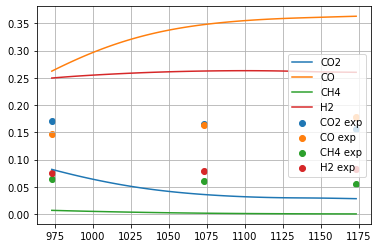

In [9]:
# First test: raw model, no modifications

for i, t in enumerate(Tl):
    report = g.gasifier(fuelID, T=t, air=ER, species=species)
    CO2l[i] = report['CO2']
    COl[i] = report['CO']
    CH4l[i] = report['CH4']
    H2l[i] = report['H2']

plt.plot(Tl, CO2l, label='CO2')
plt.plot(Tl, COl, label='CO')
plt.plot(Tl, CH4l, label='CH4') 
plt.plot(Tl, H2l, label='H2')
plt.scatter(T, experimental[:,0], label='CO2 exp')
plt.scatter(T, experimental[:,1], label='CO exp')
plt.scatter(T, experimental[:,2], label='CH4 exp')
plt.scatter(T, experimental[:,3], label='H2 exp')
plt.legend()
plt.grid()
plt.savefig("results.png")
plt.show()

162.07414155561287 0.018578890357542042
219.1611036329403 0.020465296389888425
298.3487532970771 0.021089002220340058
226.52799949521008


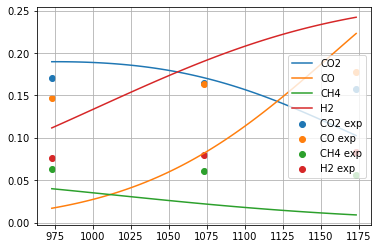

In [10]:
# Second test: modified model finds DT but not C_avail, uses average DT value

predicted = np.zeros_like(experimental)
DTsum = 0
for i, t in enumerate(T):
    DT, sqerr = g.findDT(fuelID, experimental[i], T0=t, air=ER, species=species, C_avail=1.0)
    report = g.gasifier(fuelID, T=t-DT, air=ER, species=species, C_avail=1.0)
    for j, sp in enumerate(species):
        predicted[i,j] = report[sp]
    DTsum += DT
    print(DT, sqerr)

DTav = DTsum/len(T)
print(DTav)

for i, t in enumerate(Tl):
    report = g.gasifier(fuelID, T=t-DTav, air=ER, species=species)
    CO2l[i] = report['CO2']
    COl[i] = report['CO']
    CH4l[i] = report['CH4']
    H2l[i] = report['H2']

plt.plot(Tl, CO2l, label='CO2')
plt.plot(Tl, COl, label='CO')
plt.plot(Tl, CH4l, label='CH4') 
plt.plot(Tl, H2l, label='H2')
plt.scatter(T, experimental[:,0], label='CO2 exp')
plt.scatter(T, experimental[:,1], label='CO exp')
plt.scatter(T, experimental[:,2], label='CH4 exp')
plt.scatter(T, experimental[:,3], label='H2 exp')
plt.grid()
plt.legend()
plt.savefig("results2.png")
plt.show()

162.0576502933071 1.0 0.01857889033703945
219.159747772585 1.0 0.020465296389869377
298.3535994956637 1.0 0.02108900218434423
226.5236658538519 1.0


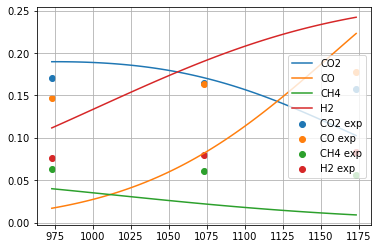

In [11]:
# Third test: modified model finds DT and C_avail, uses average values

predicted = np.zeros_like(experimental)
sums = [0, 0]
for i, t in enumerate(T):
    X = g.findParams(fuelID, experimental[i], T0=t, air=ER, species=species)
    DT, C_avail, sqerr = X
    report = g.gasifier(fuelID, T=t-DT, air=ER, species=species, C_avail=C_avail)
    for j, sp in enumerate(species):
        predicted[i,j] = report[sp]
    sums[0] += DT
    sums[1] += C_avail
    print(DT, C_avail, sqerr)
DTav = sums[0]/len(T)
C_avail_av = sums[1]/len(T)
print(DTav, C_avail_av)

for i, t in enumerate(Tl):
    report = g.gasifier(fuelID, T=t-DTav, air=ER, species=species, C_avail=C_avail_av)
    CO2l[i] = report['CO2']
    COl[i] = report['CO']
    CH4l[i] = report['CH4']
    H2l[i] = report['H2']

plt.plot(Tl, CO2l, label='CO2')
plt.plot(Tl, COl, label='CO')
plt.plot(Tl, CH4l, label='CH4') 
plt.plot(Tl, H2l, label='H2')
plt.scatter(T, experimental[:,0], label='CO2 exp')
plt.scatter(T, experimental[:,1], label='CO exp')
plt.scatter(T, experimental[:,2], label='CH4 exp')
plt.scatter(T, experimental[:,3], label='H2 exp')
plt.grid()
plt.legend()
plt.savefig("results3.png")
plt.show()